In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings
import networkx as nx


# Generating a [QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) problem instance 

Here, the task is the Quadratic Unconstrained Binary Optimization (QUBO) problem:

$\min_{\textbf{x}} \textbf{x}\ Q\ \textbf{x}$ where $\textbf{x}=(x_1,\cdots,x_n)$, every $x_i\in\{0,1\}$, and $n$ is the number of binary variables (qubits).

The real matrix $Q$ defines the problem and a $n$-component binary vector $\textbf{x}$ represents a feasible solution.
The problem is equivalent to find the minimum energy (ground) state of the Ising Hamiltonian
$H=\sum_{i,j} Q_{ij}\mathcal{P}_i \mathcal{P}_j$, where $\mathcal{P=\frac{I+Z}{2}}$ is a qubit projector. 
$\mathcal{I}$ and $\mathcal{Z}$ are the identity and Pauli z-operator.
For $i$th qubit, we have the eigenvalue equation $\mathcal{P}_i |x_i\rangle = x_i |x_i\rangle$.
In $H$, the real number $Q_{ij}$ represent zz-interaction strength between $i$th and $j$th qubit.
One can represent the whole situation through a graph like given below.


QUBO belongs to the NP-hard class of problems such as Max-Cut, Vertex Cover, etc.
For more details see: [Lucas A (2014) Ising formulations of many NP problems. Front. Physics 2:5](https://doi.org/10.3389/fphy.2014.00005)

[[  3   8  -8   0   0   0  -6   1   3  -5 -10  -5   8   0   6   1  -1]
 [  0  -2   8   2   5   0  -8   0   6   5 -10   0   1  -5 -10  -5 -10]
 [  0   0  -1   8   0   4   7   7  -7   8   5   4  -8  -8   6  -7   0]
 [  0   0   0   4   5   3  -9   5   3 -10   5   7  -1  -2   9  -3  -3]
 [  0   0   0   0   2  -2   7  -1   9   4 -10   4  -3   5  -9   8  -4]
 [  0   0   0   0   0   4  -8   4   8  -6  -5   1   7  -1   8   6   2]
 [  0   0   0   0   0   0   1   7   5   2  -7   5 -10  -8   0  -3   3]
 [  0   0   0   0   0   0   0   7   2   5  -5  -1  -1  -7   8   5  -4]
 [  0   0   0   0   0   0   0   0  -6  -1 -10  -4   3  -5  -3  -9   1]
 [  0   0   0   0   0   0   0   0   0  -8   3  -3   0  -5   5   4   9]
 [  0   0   0   0   0   0   0   0   0   0   5  -7   6   8  -5  -2   6]
 [  0   0   0   0   0   0   0   0   0   0   0  -4   9  -2  -3  -7   9]
 [  0   0   0   0   0   0   0   0   0   0   0   0   7  -4  -6  -7   5]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   7   4   9   2]
 [  0 

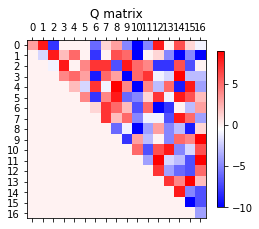

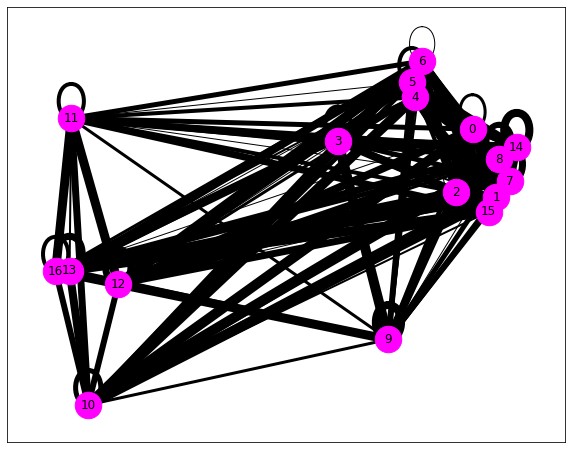

In [2]:
n = 17                                # = number of qubits
dim = 2**n                             # = dimension of the n-qubit Hilbert space

Q = np.random.randint(-10, 10, (n, n))  
Q = np.triu(Q)

print(f'{Q} = Q matrix')

def plot_Q_matrix():
    plt.matshow(Q, cmap='bwr')
    plt.xticks(np.arange(n))
    plt.yticks(np.arange(n))
    cb = plt.colorbar(shrink=0.7)
    plt.title(f'Q matrix') 
    plt.show()

plot_Q_matrix()

#---------------------------------------------------------------------------- 
'In the graph, a node represents a qubit (binary variables), width of the edge (i,j) is proportional to Q_ij'

plt.subplots(figsize=(10,8))  
g = nx.Graph()

edges = []
for i in range(n):
    for j in range(i, n):
        if Q[i,j]!=0:
            edges.append((i, j, Q[i,j]))
            
g.add_weighted_edges_from(edges)

pos = nx.spring_layout(g, seed=0)
nx.draw_networkx(g, pos, node_size= 700, node_color='magenta', 
                 width=list(nx.get_edge_attributes(g, "weight").values()))


# finding minimum energy with an exhaustive search

When $n$ is large, say 50, then the number of different energies $E_x=\langle x|H|x\rangle$ will be $2^{50}$ (an exponentially large number). As a result, it is impossible to store all of them in a computer and it is NP-hard to find a minimum energy (ground) state using the function 

energy(x, Q) $:= \textbf{x}\ Q\ \textbf{x} = E_x = \langle x|H|x\rangle$

defined below. So, in the leter parts, we will use quantum variatioal algorithms to find $x$ for which $E_x$ is as small as possible ($x=0,\cdots,2^n-1$). The binary representation of integer $x$ is $\textbf{x}$ and
$H= \text{diag}(E_x) = \sum_x E_x |x\rangle\langle x|$.


energies for different x = [...E_x...] = [  0  -4 -10 ...  45  16  13]


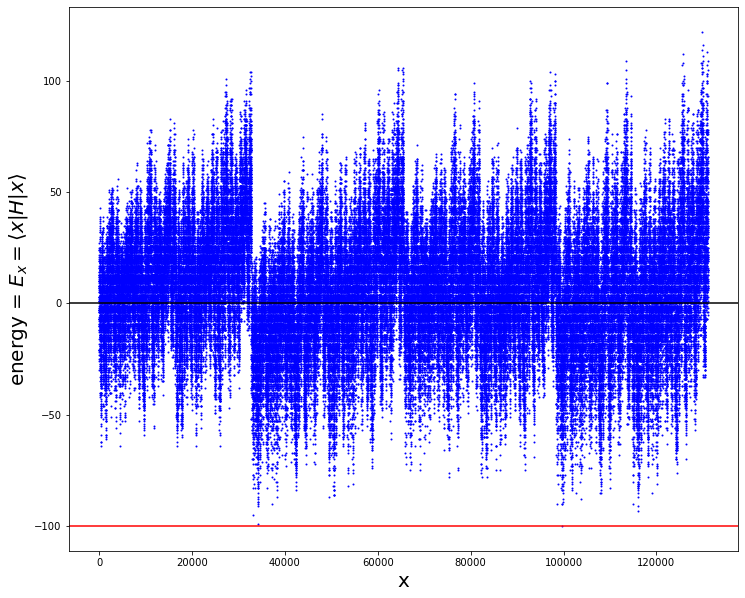

global min_energy = -100
global min_energy eigenstates = [99687] = [[1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1]]

global max_energy = 122
CPU times: user 2.24 s, sys: 189 ms, total: 2.43 s
Wall time: 2.19 s


In [15]:
%%time

def energy(x, Q):                                              # x in an integer, one-to-one correspondence: x <--> x_bin 
    x_bin = np.array([int(i) for i in np.binary_repr(x, n)])   # x_bin has n components, each one is either 0 (spin-up) or 1(spin-down)                                      
    E = np.linalg.multi_dot([x_bin, Q, x_bin])                 # E_x = energy for a given x
    return E
    

def energies(Q):
    n = Q.shape[0]                  # number of qubits
    dim = 2**n                      # dimension of the n-qubit Hilbert space
    xE = []
    for x in range(dim):                                                                                
        E = energy(x, Q)              
        xE.append([x, E])
    return np.array(xE)             # collection of all possible 2**n energies for different x

#----------------------------------------------------------------------------  
        
xE = energies(Q=Q)
engs = xE[:,1] 
print(f'energies for different x = [...E_x...] = {engs}')

#==============================================================================

min_eng = np.min(engs)
max_eng = np.max(engs)

plt.rcParams["figure.figsize"] = (12,10)
plt.scatter(np.arange(dim), engs, s=1, c='blue')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = min_eng, color = 'red', linestyle = '-')
plt.ylabel(r'energy = $E_x = \langle x|H|x\rangle$', fontsize=20)
plt.xlabel('x', fontsize=20)
plt.show()

xmins = np.where(engs==min_eng)[0]
xmins_bin = [[int(i) for i in np.binary_repr(xmin, n)] for xmin in xmins]

print(f'global min_energy = {min_eng}')
print(f'global min_energy eigenstates = {xmins} = {xmins_bin}\n')
print(f'global max_energy = {max_eng}')
    


$ $

# Solving QUBO with [Qiskit](https://qiskit.org/documentation/stable/0.19/index.html)

In [4]:
from qiskit_optimization import QuadraticProgram                         #!pip install qiskit[optimization]

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, SamplingVQE, QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer


from qiskit.primitives import Sampler
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA, COBYLA

## Writing Quadratic Program (QP) using the $Q$ matrix
__QP is the QUBO here.__

In [5]:
qp = QuadraticProgram()

for i in range(n):
    qp.binary_var(f'x{i}')

    
linear = [Q[i,i] for i in range(n)]

quadratic = {}
for i in range(n):
    for j in range(i+1, n):
        quadratic[(f'x{i}', f'x{j}')] = Q[i,j]
        

qp.minimize(linear=linear, quadratic=quadratic)
qp

<QuadraticProgram: minimize 8*x0*x1 - 10*x0*x10 - 5*x0*x11 + 8*x0*x12 + 6*x0*x..., 17 variables, 0 constraints, ''>

## (1) Solving QP=QUBO with the exact classical eigensolver

The class [__MinimumEigenOptimizer__](https://qiskit.org/ecosystem/optimization/stubs/qiskit_optimization.algorithms.MinimumEigenOptimizer.html) provides a wrapper for minimum eigen solvers from Qiskit to be used within the optimization module. It assumes a problem consisting only of binary or integer variables as well as linear equality constraints thereof. It converts such a problem into a QUBO problem by expanding integer variables into binary variables and by adding the linear equality constraints as weighted penalty terms to the objective function. The resulting QUBO is then translated into an Ising Hamiltonian whose minimal eigen vector and corresponding eigenstate correspond to the optimal solution of the original optimization problem. The provided minimum eigen solver is then used to approximate the ground state of the Hamiltonian to find a good solution for the optimization problem.

In [6]:

%%time

exact = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())
print()


objective function value: -100.0
variable values: x0=1.0, x1=1.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0, x6=1.0, x7=0.0, x8=1.0, x9=0.0, x10=1.0, x11=1.0, x12=0.0, x13=0.0, x14=1.0, x15=1.0, x16=1.0
status: SUCCESS

CPU times: user 7.67 s, sys: 55.7 ms, total: 7.73 s
Wall time: 7.72 s


## (2) Solving QP=QUBO with [VQE](https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.SamplingVQE.html)

VQE is a hybrid quantum-classical algorithm that uses a variational technique to find the minimum eigenvalue of a given diagonal Hamiltonian.

In [7]:

%%time
ansatz = TwoLocal(n, "ry", "cx", reps=3, entanglement="linear")           # construct ansatz for VQE
vqe = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=COBYLA(maxiter=10))    # construct VQE


meo_vqe = MinimumEigenOptimizer(min_eigen_solver=vqe)                                # run VQE
result_vqe = meo_vqe.solve(qp)


print(result_vqe.prettyprint())
print()


objective function value: -91.0
variable values: x0=0.0, x1=1.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0, x6=1.0, x7=0.0, x8=1.0, x9=0.0, x10=1.0, x11=1.0, x12=1.0, x13=0.0, x14=1.0, x15=1.0, x16=1.0
status: SUCCESS

CPU times: user 2min 24s, sys: 17.8 s, total: 2min 42s
Wall time: 2min 26s


## (3) Solving QP=QUBO with [QAOA](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html)

The QAOA [1] implementation directly extends VQE and inherits VQE’s optimization structure.


[1] [E. Farhi, J. Goldstone, and S. Gutmann, A Quantum Approximate Optimization Algorithm](https://doi.org/10.48550/arXiv.1411.4028)

In [8]:

%%time
qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=10), reps=3)      # construct QAOA


meo_qaoa = MinimumEigenOptimizer(min_eigen_solver=qaoa)                   # run QAOA
result_qaoa = meo_qaoa.solve(qp)


print(result_qaoa.prettyprint())
print()


objective function value: -100.0
variable values: x0=1.0, x1=1.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0, x6=1.0, x7=0.0, x8=1.0, x9=0.0, x10=1.0, x11=1.0, x12=0.0, x13=0.0, x14=1.0, x15=1.0, x16=1.0
status: SUCCESS

CPU times: user 3min 55s, sys: 1min, total: 4min 55s
Wall time: 3min 41s


# $ $




$ $

## My other implementations for QUBO:

- I have solved QUBO by implementing QAOA with PyTorch [see [the notebook](https://github.com/ArunSehrawat/Quantum_Approximate_Optimization_Algorithm_for_Quadratic_Unconstrained_Binary_Optimization_PyTorch/blob/main/Quantum_Approximate_Optimization_Algorithm_for_Quadratic_Unconstrained_Binary_Optimization_using_PyTorch.ipynb)]

- I have solved QUBO also by implementing another Quantum Variational Algorithm with PyTorch [see [the notebook](https://github.com/ArunSehrawat/Variational_Quantum_Algorithms_for_Quadratic_Unconstrained_Binary_Optimization_using_PyTorch/blob/main/Variational_Quantum_Algorithms_for_Quadratic_Unconstrained_Binary_Optimization_using_PyTorch.ipynb)]